In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Collect the names of tables within the database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
inspector.get_columns('measurement')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date[0]

'2017-08-23'

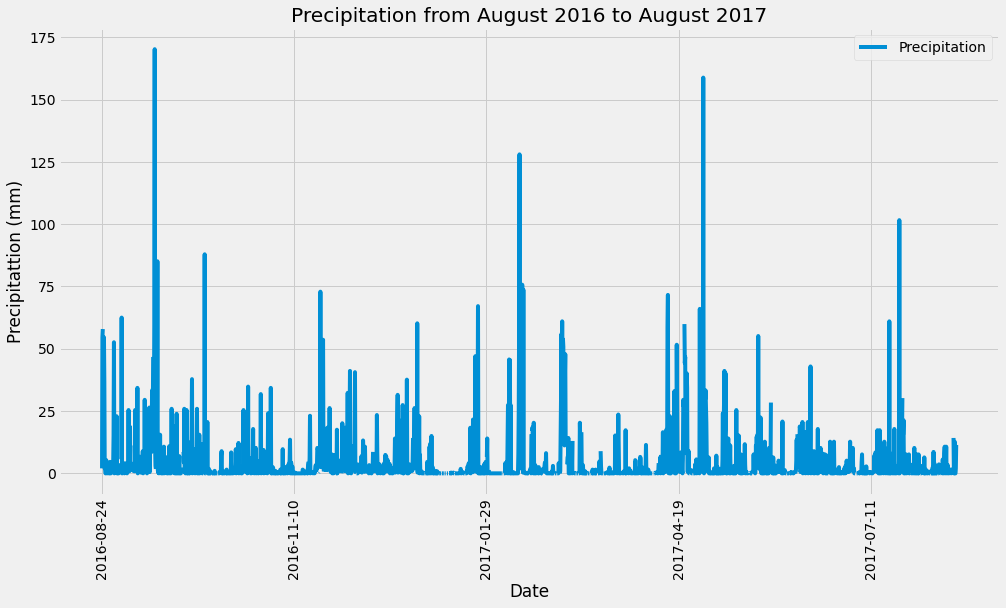

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
most_recent_date_str = dt.datetime.strptime(most_recent_date[0], "%Y-%m-%d").date()
# Calculate the date one year from the last date in data set.
one_year_back = dt.datetime.strptime(most_recent_date[0], "%Y-%m-%d") - dt.timedelta(days=365)
one_year_back

# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_back)\
.order_by(Measurement.date.asc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_scores, columns=["Date", "Precipitation"]).set_index("Date")

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(kind="line", grid=True, figsize=(15,8))
plt.ylabel("Precipitattion (mm)")
plt.xlabel("Date")
plt.title("Precipitation from August 2016 to August 2017")
plt.xticks(rotation=90)
plt.savefig("images/precipitation.png")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,4.485112
std,11.690532
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station.id).count()
total_stations

9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations
print(f' Station ID: {active_stations[0][0]} is the most active')

 Station ID: USC00519281 is the most active


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_id = active_stations[0][0]
station_summary_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == active_station_id).all()
station_summary_stats
print(f'min temperature is {station_summary_stats[0][0]}C, max temperature is {station_summary_stats[0][1]}C, average temperature is {round(station_summary_stats[0][2],1)}C')

min temperature is 12.2C, max temperature is 29.4C, average temperature is 22.0C


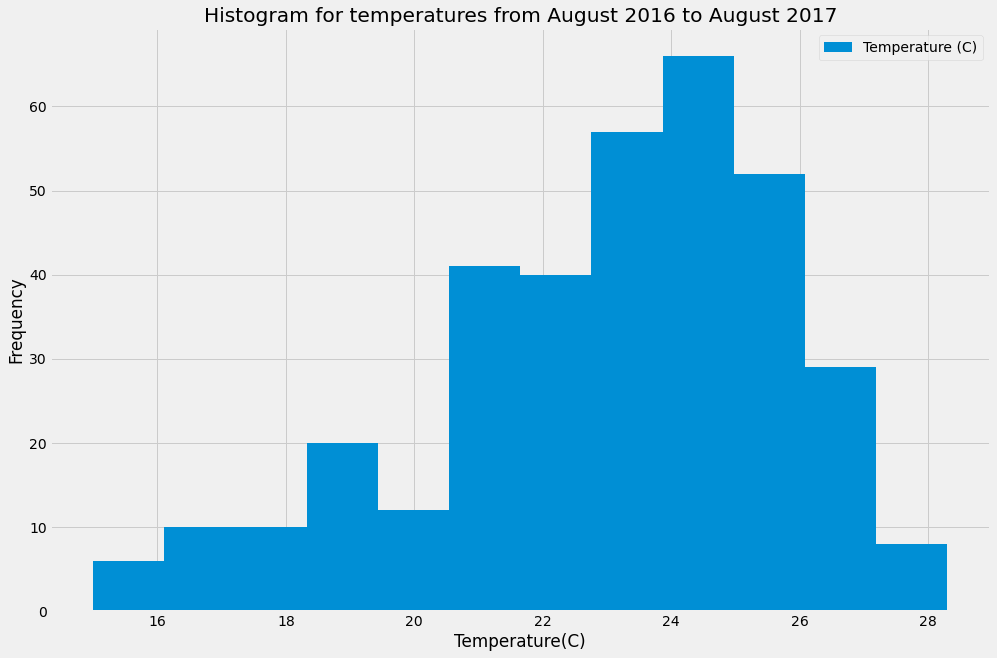

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_12months = session.query(Measurement.tobs).filter(Measurement.date >= one_year_back).filter(Measurement.station==active_stations[0][0]).all()
temps_df = pd.DataFrame(temp_12months, columns=["Temperature (C)"])
temps_df.plot(figsize=(15,10), kind="hist",bins=12,grid=True, )
plt.title("Histogram for temperatures from August 2016 to August 2017")
plt.xlabel("Temperature(C)")
plt.savefig("images/station-histogram.png")
plt.show()


# Close session

In [18]:
# Close Session
session.close()